In [5]:
import numpy as np
from numpy.fft import fft
from scipy.integrate import quad
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
import time

In [2]:
S0 = 100.00 
K = 100.00  
T = 1.  
r = 0.05
sigma = 0.2 

    ''' Valuation of European call option in BSM model via Lewis (2001)
    --> Fourier-based approach (integral).

    Parameters
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    sigma: float
        volatility factor in diffusion term

    Returns
    =======
    call_value: float
        European call option present value
    '''


In [3]:
#
# Call Valuation by Analytical Solution
#

def BSM_call_value(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) \
        / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) \
        / (sigma * np.sqrt(T))
    BS_C = (S0 * stats.norm.cdf(d1, 0.0, 1.0) -
            K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    return BS_C

In [4]:
BSM_call_value(S0, K, T, r, sigma)

10.450583572185565

In [8]:
#
# Fourier Transform with Numerical int_valueegration
#     ''' Valuation of European call option in BSM model via Lewis (2001)
#     --> Fourier-based approach (integral).

def BSM_call_value_INT(S0, K, T, r, sigma):
    int_value = quad(lambda u:
                     BSM_integral_function(u, S0, K, T, r, sigma), 0, 100)[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) /
                     np.pi * int_value)
    return call_value

def BSM_integral_function(u, S0, K, T, r, sigma):
    cf_value = BSM_characteristic_function(u - 1j * 0.5, 0.0, T, r, sigma)
    int_value = 1 / (u ** 2 + 0.25) \
        * (np.exp(1j * u * np.log(S0 / K)) * cf_value).real
    return int_value

def BSM_characteristic_function(v, x0, T, r, sigma):
    cf_value = np.exp(((x0 / T + r - 0.5 * sigma ** 2) * 1j * v -
                       0.5 * sigma ** 2 * v ** 2) * T)
    return cf_value


In [9]:
#
# Numerical Solution:Fourier Transform with FFT
#


def BSM_call_value_FFT(S0, K, T, r, sigma):
    k = np.log(K / S0)
    x0 = np.log(S0 / S0)
    g = 1  # factor to increase accuracy
    N = g * 4096
    eps = (g * 150.) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)
    # Modificatons to Ensure int_valueegrability
    if S0 >= 0.95 * K:  # ITM case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (BSM_characteristic_function(
            v, x0, T, r, sigma) /
            (alpha ** 2 + alpha - vo ** 2 + 1j * (2 * alpha + 1) * vo))
    else:        # OTM case
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (1 / (1 + 1j * (vo - 1j * alpha)) -
                             np.exp(r * T) / (1j * (vo - 1j * alpha)) -
                             BSM_characteristic_function(v, x0, T, r, sigma) /
                             ((vo - 1j * alpha) ** 2 -
                              1j * (vo - 1j * alpha)))
        v = (vo + 1j * alpha) - 1j
        modcharFunc2 = np.exp(-r * T) * (1 / (1 + 1j * (vo + 1j * alpha))
                             - np.exp(r * T) /
                             (1j * (vo + 1j * alpha))
                             - BSM_characteristic_function(
            v, x0, T, r, sigma) /
            ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha)))
    # Numerical FFT Routine
    delt = np.zeros(N, dtype=np.float)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (np.exp(1j * b * vo) *
                   (modcharFunc1 - modcharFunc2) *
                   0.5 * eta * SimpsonW)
        payoff = (fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)
    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0
    # klist = np.exp((np.arange(0, N, 1) - 1) * eps - b) * S0
    return CallValue  # , klist[pos - 50:pos + 50]


In [11]:
start_time=time.time()
BSM_call_value(S0, K, T, r, sigma)
end_time=time.time()
print('Simple BSM time: ',end_time-start_time)

start_time=time.time()
BSM_call_value_INT(S0, K, T, r, sigma)
end_time=time.time()
print('Int BSM time: ',end_time-start_time)


start_time=time.time()
BSM_call_value_FFT(S0, K, T, r, sigma)
end_time=time.time()
print('FFT BSM time: ',end_time-start_time)


Simple BSM time:  0.0006926059722900391
Int BSM time:  0.0025920867919921875
FFT BSM time:  0.00406193733215332


<ipython-input-9-45c183a7f39f>:61: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  delt = np.zeros(N, dtype=np.float)


In [12]:
def plot_val_differences(vtype='int'):
    k_list = np.linspace(S0 * 0.6, S0 * 1.4, 50)
    ana_values = BSM_call_value(S0, k_list, T, r, sigma)
    plt.figure(figsize=(8, 6))
    plt.subplot(311)
    plt.plot(k_list, ana_values, 'b', label='analytical', lw=1.5)
    if vtype == 'int':
        int_values = np.array([BSM_call_value_INT(S0, K, T, r, sigma)
                               for K in k_list])
        plt.plot(k_list, int_values, 'r-.', label='Fourier (integral)', lw=1.5)
        diffs = int_values - ana_values
        rdiffs = (int_values - ana_values) / ana_values
    else:
        fft_values = np.array([BSM_call_value_FFT(S0, K, T, r, sigma)
                               for K in k_list])
        plt.plot(k_list, fft_values, 'r-.', label='Fourier (FFT)', lw=1.5)
        diffs = fft_values - ana_values
        rdiffs = (fft_values - ana_values) / ana_values
    plt.legend()
    plt.subplot(312)
    plt.plot(k_list, diffs, 'g', label='abs. difference', lw=1.5)
    plt.legend(loc=0)
    plt.subplot(313)
    plt.plot(k_list, rdiffs, 'r', label='rel. difference', lw=1.5)
    plt.legend(loc=0)
    plt.xlabel('strike')
    plt.tight_layout()

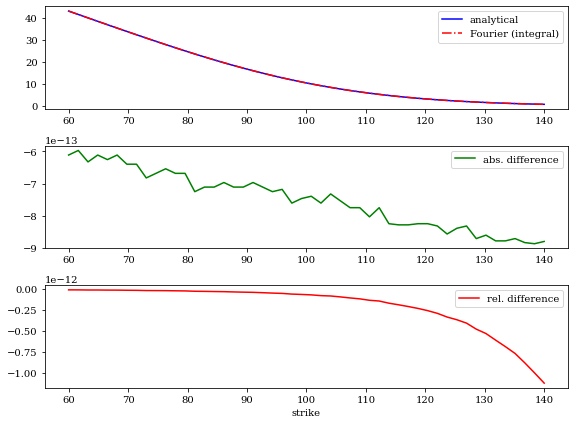

In [13]:
plot_val_differences()